In [1]:
! sudo apt update -y && sudo apt-get install -y poppler-utils -qq

Hit:1 http://deb.debian.org/debian bullseye InRelease
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]    
Hit:4 https://dl.yarnpkg.com/debian stable InRelease          
Fetched 92.4 kB in 0s (255 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
6 packages can be upgraded. Run 'apt list --upgradable' to see them.


In [2]:
! pip install pdf2image fpdf2 datasets --quiet

In [3]:
import datasets
from pdf2image import convert_from_bytes
from fpdf import FPDF
from io import BytesIO
from PIL import Image
import os
import json
import pandas as pd
SELECT_RANGE = 10

/workspaces/lowem1-experiments-n-notes/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = datasets.load_dataset("cc_news")

In [5]:
dataset = dataset["train"]

In [6]:
sample = dataset.select(range(10))["text"]

In [7]:
class SimpleDoc(FPDF):
    def __init__(self) -> None:
        super().__init__()
        self.ch = 8
        return

    def header(self) -> None:
        return

    def footer(self) -> None:
        return
    
    def body(self, text: str) -> None:
        ch = self.ch
        text = text.encode("UTF-8")
        self.add_page()
        self.set_font('Arial', 'B', 8)
        self.multi_cell(0, 5, text.decode("Latin-1"))
        # Line break
        self.ln()

In [8]:
doc = SimpleDoc()

In [9]:
sample[-1]

'Looking for your next audition shoe? Shot at and in collaboration with Broadway Dance Center, Só Dança has launched a new collection of shoes working with some pretty famous faces of the musical theater world! Offered in two different styles and either 2.5" or 3" heels, top industry professionals are loving how versatile and supportive these shoes are! Pro tip: The heel is centered under the body so you can feel confident and stable!'

In [10]:
doc.body(text=sample[-1])

/tmp/ipykernel_179693/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_font('Arial', 'B', 8)


In [11]:
stream = BytesIO(doc.output(dest="S"))
stream.seek(0)
images = convert_from_bytes(stream.read(), 200)
for i, image in enumerate(images):
    image.save("/tmp/test.png")

/tmp/ipykernel_179693/2280367534.py:1: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  stream = BytesIO(doc.output(dest="S"))


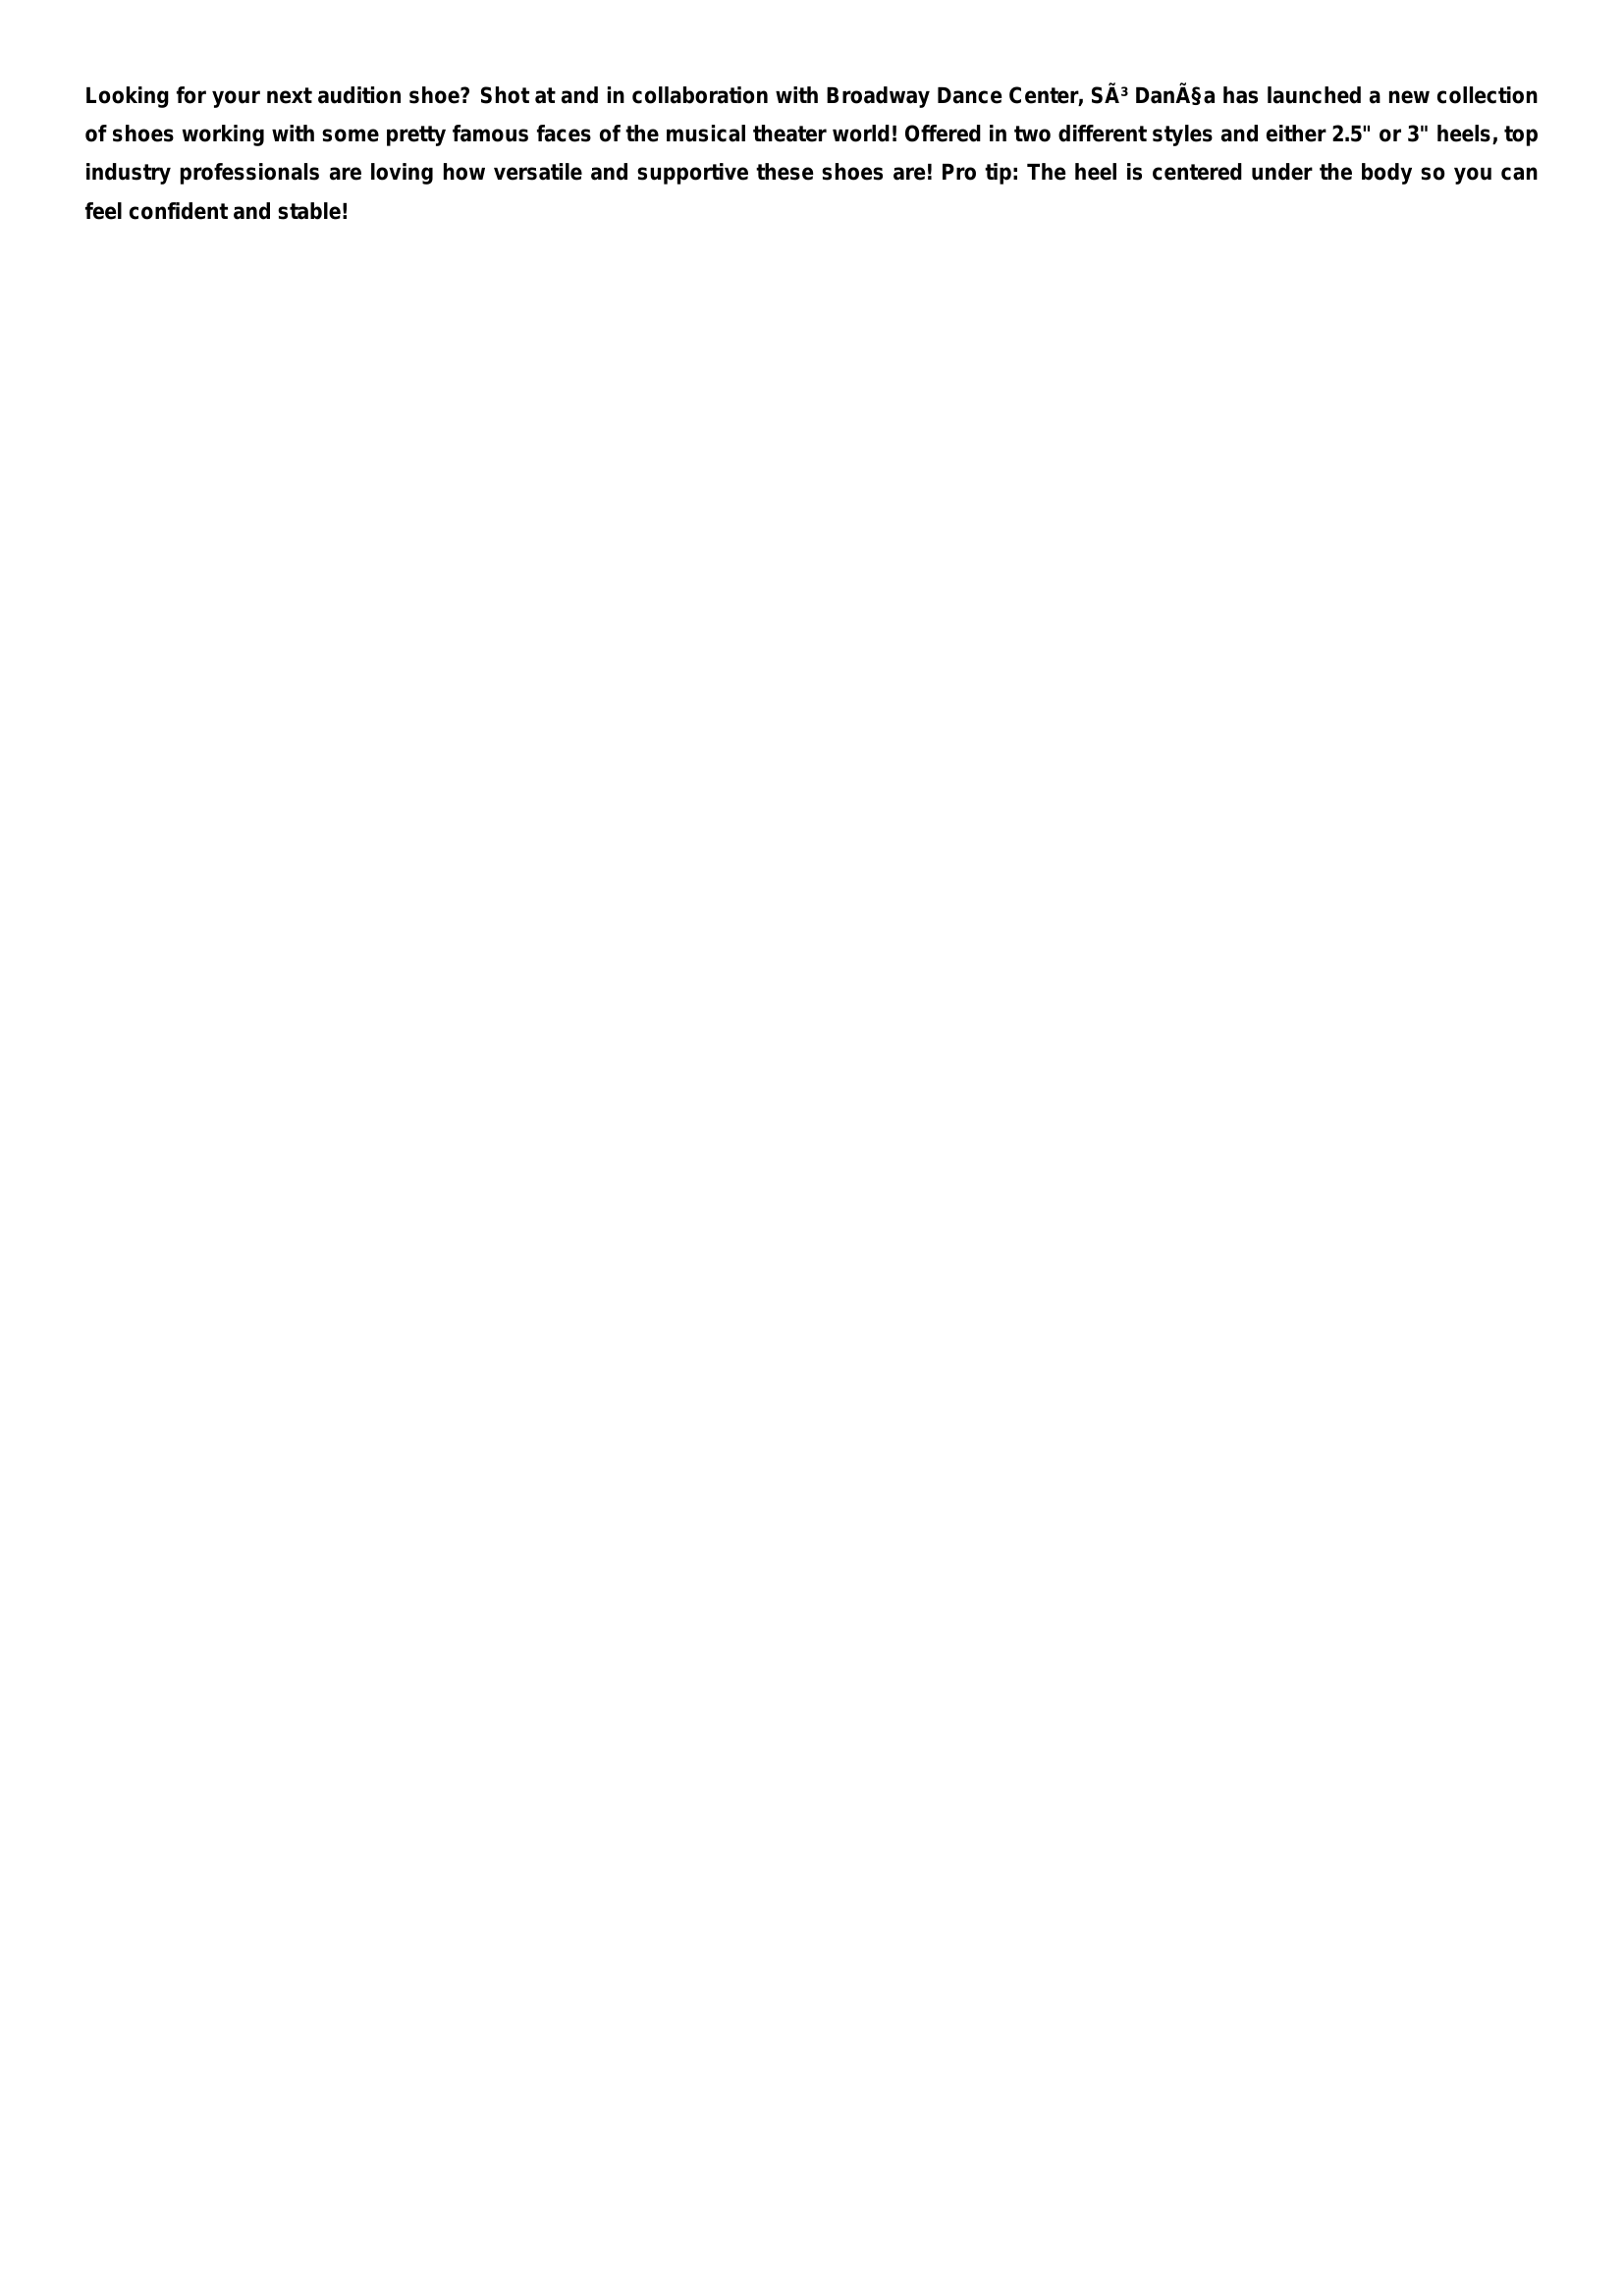

In [12]:
Image.open("/tmp/test.png")

### Load Data And Product Image Dataset

In [13]:
doc_set = (
    dataset
    .shuffle()
    .select(range(SELECT_RANGE))
    .select_columns(["text"])
).to_pandas()


In [14]:
metadata = []
for i, row in enumerate(doc_set.itertuples()):
    doc = SimpleDoc()
    doc.body(text=row.text)
    stream = BytesIO(doc.output(dest="S"))
    stream.seek(0)
    base_dir = "/tmp/cc_news_images"
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    for j, image in enumerate(convert_from_bytes(stream.read(), 200)):
        filename = f"{base_dir}/doc_{i}-{j}.png"
        record = dict(file_name=f"doc_{i}-{j}.png", text=row.text)
        metadata.append(record)
        image.save(filename)
    del(doc)
    del(stream)

/tmp/ipykernel_179693/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_font('Arial', 'B', 8)
/tmp/ipykernel_179693/4256289548.py:5: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  stream = BytesIO(doc.output(dest="S"))
/tmp/ipykernel_179693/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_font('Arial', 'B', 8)
/tmp/ipykernel_179693/4256289548.py:5: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  stream = BytesIO(doc.output(dest="S"))
/tmp/ipykernel_179693/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_font('Arial', 'B', 8)
/tmp/ipykernel_179693/4256289548.py:5: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
  stream = BytesIO(doc.output(dest="S"))
/tmp/ipykernel_179693/233455760.py:17: UserWarning: Substituting font arial by core font helvetica
  self.set_fo

In [15]:
metadata

[{'file_name': 'doc_0-0.png',
  'text': 'Not quite pool season in Santa Fe, yet.\nTonight: I am at the Jean Cocteau Cinema in Santa Fe, having conversation with George RR Martin. As one does!\nTomorrow: Boulder, Colorado, at the Boulder bookstore. Really looking forward to that.\nHello world! I’m back on tour!'},
 {'file_name': 'doc_1-0.png',
  'text': 'When the Almighty set about to make Bostonians he made them from sturdy stock.\nFrom Bunker Hill to the marathon bombing, they have shown the nation what it means to be Boston Strong.\nClick here to join Conservative Patriots on Todd’s Facebook page!\nIt’s been four years since that day — the day Islamic radicals waged jihad on the Boston Marathon. Four people were killed. Sixteen people lost their legs — in the name of the religion of peace.\nThere are some who would rather we forget about the carnage of that day, April 15, 2013 — but we cannot and we must not.\nWe must never forget what the Islamic radicals did to us — the blood they 

In [16]:
pd.DataFrame(metadata).to_csv(f"{base_dir}/metadata.csv", index=False)

In [18]:
# dt = datasets.load_dataset("imagefolder", data_dir="/tmp/cc_news_images/")

In [19]:
# dt.push_to_hub("lowem1/cc_news_images")